# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
import statsmodels.api as sm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#Reading the data file into a pandas Dataframe
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df['timestamp'].min(),df['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [5]:
#Identifing the shape of the Dataframe
df.shape

(294478, 5)

In [6]:
#Caculating the proportion of the conversion rate
df['converted'].mean()

0.11965919355605512

In [7]:
#Investigating missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**-There are no missing values in our columns in the Dataframe**

In [8]:
#Detecting the Number of rows where the group and the landing page don't match correctly
eror1 = df.query("group == 'treatment'")
print(eror1['landing_page'].value_counts())
eror2 =df.query("group == 'control'")
print(eror2['landing_page'].value_counts())
print(1965+1928)

new_page    145311
old_page      1965
Name: landing_page, dtype: int64
old_page    145274
new_page      1928
Name: landing_page, dtype: int64
3893


**-There are a toltal of 3893 rows where the data don't match correctly**

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 =df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index)
df2 = df2.drop(df2[(df['group'] == 'control') &(df2['landing_page'] == 'new_page')].index)
print(df2.shape)

(290585, 5)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
#Counting the number of unique user_ids
df2['user_id'].nunique()

290584

**-There is one user_id repeated in df2**

In [12]:
#Show the row with the Duped user_id
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Removing one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 =df2.drop(df2[df2['user_id'].duplicated() == True].index)
# Check again if the row with a duplicate user_id is deleted or not
df2.shape

(290584, 5)

In [14]:
#The proportion of the conversion probability in the dataset
df2['converted'].mean()

0.11959708724499628

In [15]:
#The proportion of the conversion probability in the control group
p_ctrl = df2.query("group == 'control'")['converted'].mean()
p_ctrl

0.1203863045004612

In [28]:
#The proportion of the conversion probability in the treatment group
p_ttt = df2.query("group == 'treatment'")['converted'].mean()
p_ttt

0.11880806551510564

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [30]:
obs_diff = df2['converted'][df2['group'] == 'treatment'].mean() - df2['converted'][df2['group'] == 'control'].mean()
obs_diff

-0.0015782389853555567

In [40]:
# Calculating the observed difference (obs_diff) between the conversion rates for the two groups.
obs_diff = 0.11880806551510564 - 0.1203863045004612
obs_diff

-0.0015782389853555567

**-From this initial simple analysis it seems that the new page doesn't contribute in increasing the conversion rate**
**But we need further analysis to be sure**

<a id='ab_test'></a>
## Part II :Hypthesisi Testing (A/B Testing):

**Our Null Hypothesis is that the old page conversion rate is equal or higher than the new page conversion rate
$H_0$** : **$p_{old}$** >= **$p_{new}$**

**Our Null Hypothesis is that the new page conversion rate is higher than the old page conversion rate $H_1$** :  **$p_{new}$** > **$p_{old}$**

In [31]:
# Number of users in the treatmenr group
df2.query("group == 'treatment'")['user_id'].count()

145310

In [32]:
# Number of users in the control group
df2.query("group == 'control'")['user_id'].count()

145274

In [33]:
# Simulate a Sample for the treatment Group
ttt = df2.query("group == 'treatment'")['converted']
new_page_converted =np.random.choice(ttt,size = 145310)
new_page_converted.mean()

0.11950313123666643

In [34]:
# Simulate a Sample for the control Group
ctrl = df2.query("group == 'control'")['converted']
old_page_converted =np.random.choice(ctrl,size = 145274)
old_page_converted.mean()

0.12031746905846882

In [35]:
#Calculating the difference in conversion rates
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00081433782180238834

In [36]:
# Creating a Sampling distribution 
p_diffs = []
for i in range (10000):
    ttt = df2.query("group == 'treatment'")['converted']
    ctrl = df2.query("group == 'control'")['converted']
    new_page_converted =np.random.choice(ttt,size = 200)
    old_page_converted =np.random.choice(ctrl,size = 200)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean()) 

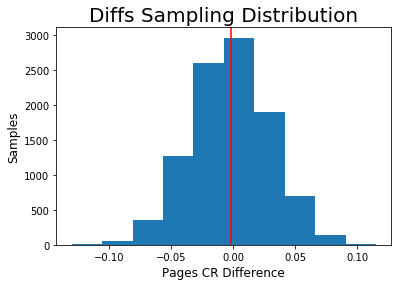

In [38]:
#plotting a histogram of the diffs array (resulted from the sampling distribution)
# and pointing the observed difference from the original samples
diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.title('Diffs Sampling Distribution', fontsize = 20);
plt.xlabel('Pages CR Difference',fontsize = 12);
plt.ylabel('Samples',fontsize = 12)
plt.axvline(obs_diff,color = 'red');

**Now we calculate the P-value which is the probability of the alternative to be true under the null hypothesis**

**Meaning the probability of the difference between the conversion rates to be more than (0) when we assume that it is less than or equal to (0)**

In [41]:
#Calculating proportion of the p_diffs are greater than the actual difference observed in the df2 data
(diffs > obs_diff).mean()

0.50929999999999997

**With a p-value higher than the alpha (probability of Type I error 5%) we fail to reject the null hypothesis as there are no statistical evidence that the alternative hypothesis is true** 

<a id='regression'></a>
### Part III - A regression approach

**As the response variable that we want to predict is a categorical variable (converted or not converted) we will use a logestic regression model**

In [42]:
#Creating the necessary dummy variables to fit our logestic reggression model
df2[['control','treatment']] = pd.get_dummies(df2['group'])
print(df2.head())
df2 = df2.drop('control',axis =1)
df2.head()

   user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   control  treatment  
0        1          0  
1        1          0  
2        0          1  
3        0          1  
4        1          0  


,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [43]:
#Using Statsmodels library to fit the logestic regression model
df2['intercept'] = 1
logm = sm.Logit(df2['converted'],df2[['intercept','treatment']])
results = logm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-25 17:43 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**The P-value obtained from the regression model for the treatment variable is 0.1899 which means that this variable is not significant in predicting the response variable (conversion)**

In [44]:
#To interpret the coefficient we need to get the  exponentiated coeffecient
np.exp(-0.0150)

0.98511193960306265

**This translates to : with using the new page we expect a multiplicative change in the odds of conversion by 0.9851 which is less than 1 so it's actually a decrease in the odds**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Put your answer here.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [45]:
# Read the countries.csv
cdf = pd.read_csv('countries.csv')
cdf.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [46]:
# Join with the df2 dataframe
df_joined = df2.join(cdf.set_index('user_id'), on='user_id')
print(df_joined.shape)
df_joined.head()

(290584, 8)


,user_id,timestamp,group,landing_page,converted,treatment,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [47]:
#counting the countries in our joined Dataframe
df_joined['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [51]:
# Creating the necessary dummy variables with CA as the baseline category
df_joined[['CA','UK','US']] = pd.get_dummies(df_joined['country'])
df_joined = df_joined.drop('CA',axis = 1)
df_joined['UK_ttt'] = df_joined['UK']*df_joined['treatment']
df_joined['US_ttt'] = df_joined['US']*df_joined['treatment']
df_joined.head()

,user_id,timestamp,group,landing_page,converted,treatment,intercept,country,UK,US,UK_ttt,US_ttt
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1,0,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [52]:
# Fitting your model, and summarize the results
logm2 =sm.Logit(df_joined['converted'],df_joined[['intercept','treatment','UK','US','UK_ttt','US_ttt']])
results2 = logm2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-25 17:49 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
treatment     -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ttt         0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ttt         0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [54]:
#Calculating exponentiated coefficients
np.exp(-0.0674), np.exp(0.0118), np.exp(0.0175),np.exp(0.0783),np.exp(0.0469)

(0.93482119806188357,
 1.011869894648401,
 1.0176540221507617,
 1.0814470441230692,
 1.0480172021191829)

**By calculating the exponentiated coefficients we can conclude that:**
> 1.The use of the new page doesn't cause more conversion.

>2. By implementig high order terms (interaction between the new page and the country), we obtained more relevant explanatory variables with higher coefficients in our model

> 3.Users from Uk have higher conversion rate than users from US compared to the baseline (lowest) which is CA.

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**


## **Final Conclusion:**
>**The company should not proceed with the new page as it didn't show statistical evidence to be producing more revenue through increasing the users conversion rate.**

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])